In [1]:
# Import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import families
import statsmodels.formula.api as smf
import scipy.stats

# allow multiple outputs in jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display to show all rows
pd.set_option('display.max_rows', None)

# set display to show all columns
pd.set_option("display.max.columns", None)

### Load County Health Rankings Data

In [2]:
# import data into county_health_data data frame
county_health_rank = pd.read_csv('county_health_2021.csv')

# rename headers using 1st row of data
county_health_rank = county_health_rank.rename(columns=county_health_rank.iloc[0])

# delete 1st row (which is now a duplicate of the header)
county_health_rank = county_health_rank.drop(county_health_rank.index[0])

# view first 5 rows of county_health_data data frame (note that there appears to be no index 0)
#county_health_rank.head()

# select only desired columns
cols = ['statecode', 'countycode', 'fipscode', 'state', 'county', 'v166_rawvalue', 'v003_rawvalue', 'v004_rawvalue', 'v153_rawvalue',
        'v060_rawvalue', 'v154_rawvalue', 'v062_rawvalue', 'v132_rawvalue', 'v005_rawvalue', 'v061_rawvalue']

county_health_rank = county_health_rank[cols]

# view first 5 rows
county_health_rank.head()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

,statecode,countycode,fipscode,state,county,v166_rawvalue,v003_rawvalue,v004_rawvalue,v153_rawvalue,v060_rawvalue,v154_rawvalue,v062_rawvalue,v132_rawvalue,v005_rawvalue,v061_rawvalue
1,00,000,00000,US,United States,0.826664922,0.1244966054,0.0007581256,0.6399214141,0.105,0.1443735922,0.002612056,0.8416869169,4236,372.8
2,01,000,01000,AL,Alabama,0.7639912993,0.1514929638,0.0006520221,0.6878059932,0.145,0.1205779357,0.0010829695,0.6111228737,5466,330.4
3,01,001,01001,AL,Autauga County,0.8056736926,0.1300796103,0.0004676175,0.7329064822,0.127,0.1337588929,0.0002863842,0.6913012406,6650,230.2
4,01,003,01003,AL,Baldwin County,0.8181638453,0.1675343756,0.000701764,0.7524527369,0.103,0.1117404539,0.000985513,0.7371354895,3471,169.3
5,01,005,01005,AL,Barbour County,0.6052434457,0.1767323062,0.0003215305,0.608988764,0.175,0.1427071179,0.0001215264,0.5316676986,5314,471


In [3]:
# rename variables
county_health_rank.rename(columns={"v166_rawvalue": "broadband", "v003_rawvalue": "uninsured_adults", "v004_rawvalue": "primary_phys",
                                   "v153_rawvalue": "home_ownership", "v060_rawvalue": "diabetes", "v154_rawvalue": 'severe_housing_cost', 
                                   "v132_rawvalue": "access_exercise", "v062_rawvalue": "mental_hlth", "v005_rawvalue": "prevent_hosp_stay",
                                   "v061_rawvalue": "HIV_prev"}, inplace=True)
# select variables
select = ["broadband","uninsured_adults","primary_phys","home_ownership","diabetes","severe_housing_cost", "access_exercise", 
          "mental_hlth", "prevent_hosp_stay","HIV_prev"]

# determine data type of above variables
#county_health_rank[select].dtypes

# convert data type of above variables from object to float or int
county_health_rank[select] = county_health_rank[select].astype(float)
county_health_rank['fipscode'] = county_health_rank['fipscode'].astype(int)

# determine data type of above variables
county_health_rank[select].dtypes

broadband              float64
uninsured_adults       float64
primary_phys           float64
home_ownership         float64
diabetes               float64
severe_housing_cost    float64
access_exercise        float64
mental_hlth            float64
prevent_hosp_stay      float64
HIV_prev               float64
dtype: object

### Load Excess Deaths Data

In [4]:
# import data into excess deaths data frame
deaths = pd.read_csv('ExcessDeaths_Obesity.csv')

# rename columns
deaths.rename(columns={'CountyName': 'county_name', 'TOTPOP_CY': 'total_county_pop', 'Deaths': 'total_deaths', 
                              'Expected': 'expected_deaths', 'Abnormal': 'abnormal_deaths', 'Excess': 'excess_deaths'}, inplace=True)

# check data type of Excess deaths column
deaths['excess_deaths'].dtypes

# select only desired columns
cols_2 = ['ID','county_name','State','total_county_pop','total_deaths','expected_deaths','abnormal_deaths','excess_deaths','COVID19']
deaths = deaths[cols_2]

# display first 5 rows
deaths.head()

dtype('int64')

,ID,county_name,State,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,1001,Autauga County,AL,57692,404,387,17,17,28
1,1003,Baldwin County,AL,219443,1775,1841,-66,0,94
2,1005,Barbour County,AL,27401,220,232,-12,0,16
3,1007,Bibb County,AL,23276,155,196,-41,0,19
4,1009,Blount County,AL,59231,397,541,-144,0,12


### Load Google Street View Features Data

In [5]:
# import google street view file
gsv = pd.read_csv('gsv_indicators_summarized_county.csv')

# rename columns
gsv.rename(columns={'county': 'fipscode'}, inplace=True)

# first 5 rows
gsv.head()

# check data type of county column
gsv['fipscode'].dtypes

,fipscode,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,1001,0.969148,0.005288,0.089308,0.677698,0,0.343879,0.085365,0.083976
1,1003,0.947018,0.007764,0.116095,0.677067,0,0.436140,0.108644,0.097183
2,1005,0.978433,0.004444,0.102145,0.665148,0,0.277878,0.043388,0.071833
3,1007,0.992821,0.002094,0.046022,0.732843,0,0.242073,0.035595,0.054354
4,1009,0.972386,0.002662,0.115099,0.674392,0,0.358319,0.032216,0.087506


dtype('int64')

### Load County Shapefile

In [6]:
# read in counties shapefile
counties = gpd.read_file('county_files/tl_2021_us_county.shp')

# first 5 rows
counties.head()

# convert GEOID column to integer
counties['GEOID'] = counties['GEOID'].astype(int)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350..."


### Load MSA Shapefile

In [7]:
# read in MSA shapefile
MSA = gpd.read_file('MSA_files/tl_2021_us_cbsa.shp')

,CSAFP,CBSAFP,GEOID,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654607902,26109459,+33.9439840,-083.2138965,"POLYGON ((-83.36003 34.04057, -83.36757 34.043..."
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22495873026,386782308,+33.6937280,-084.3999113,"POLYGON ((-84.27014 32.99101, -84.27084 32.991..."
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438775279,301270067,+39.4693555,-074.6337591,"POLYGON ((-74.58640 39.30989, -74.58665 39.309..."
3,426,12120,12120,"Atmore, AL","Atmore, AL Micro Area",M2,2,G3110,2448595161,20024887,+31.1222867,-087.1684097,"POLYGON ((-87.36388 30.99790, -87.36391 30.997..."
4,258,12140,12140,"Auburn, IN","Auburn, IN Micro Area",M2,2,G3110,939731961,2657419,+41.3967596,-085.0026969,"POLYGON ((-85.07780 41.26560, -85.07850 41.265..."


In [8]:
# convert GEOID and MEMI column to integer
MSA['GEOID'] = MSA['GEOID'].astype(int)
MSA['MEMI'] = MSA['MEMI'].astype(int)

# remove unecessary columns
MSA.drop(['CSAFP', 'CBSAFP', 'ALAND','AWATER', 'MTFCC', 'INTPTLAT', 'INTPTLON'], axis=1, inplace=True)

# remove micropolitan statistical areas by filtering
MSA.drop(MSA.index[MSA['MEMI'] == 2], inplace=True)

# check that drop was successful
MSA.head()

,GEOID,NAME,NAMELSAD,LSAD,MEMI,geometry
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043..."
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991..."
2,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,"POLYGON ((-74.58640 39.30989, -74.58665 39.309..."
6,12220,"Auburn-Opelika, AL","Auburn-Opelika, AL Metro Area",M1,1,"POLYGON ((-85.16535 32.47097, -85.16725 32.470..."
7,12260,"Augusta-Richmond County, GA-SC","Augusta-Richmond County, GA-SC Metro Area",M1,1,"POLYGON ((-81.65176 33.81451, -81.64701 33.818..."


### Load State Shapefile

In [53]:
# read in states shapefile
states = gpd.read_file('state_files/cb_2018_us_state_20m.shp')

# first 5 rows
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [54]:
# convert GEOID column to integer
states['GEOID'] = states['GEOID'].astype(int)

# remove unecessary columns
states.drop(['STATENS', 'AFFGEOID', 'LSAD','ALAND','AWATER'], axis=1, inplace=True)

#rename variables
states.rename(columns={"STUSPS": "state_short", "NAME": "state_long"}, inplace=True)

# check that drop was successful
states.head()

,GEOID,NAME,NAMELSAD,LSAD,MEMI,geometry
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043..."
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991..."
2,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,"POLYGON ((-74.58640 39.30989, -74.58665 39.309..."
6,12220,"Auburn-Opelika, AL","Auburn-Opelika, AL Metro Area",M1,1,"POLYGON ((-85.16535 32.47097, -85.16725 32.470..."
7,12260,"Augusta-Richmond County, GA-SC","Augusta-Richmond County, GA-SC Metro Area",M1,1,"POLYGON ((-81.65176 33.81451, -81.64701 33.818..."


### Join datasets together

In [9]:
# join excess deaths and county health rankings dataframes
excess_county_hlth = pd.merge(county_health_rank,deaths,left_on='fipscode',right_on='ID')

# check data type
excess_county_hlth.dtypes

# remove duplicate info
excess_county_hlth.drop(['ID', 'county_name', 'State'], axis=1, inplace=True)

# check results
excess_county_hlth.head()

# drop rows with NaN
excess_county_hlth = excess_county_hlth.dropna()
excess_county_hlth.isna().sum().sum() #check if successful

statecode               object
countycode              object
fipscode                 int64
state                   object
county                  object
broadband              float64
uninsured_adults       float64
primary_phys           float64
home_ownership         float64
diabetes               float64
severe_housing_cost    float64
mental_hlth            float64
access_exercise        float64
prevent_hosp_stay      float64
HIV_prev               float64
ID                       int64
county_name             object
State                   object
total_county_pop         int64
total_deaths             int64
expected_deaths          int64
abnormal_deaths          int64
excess_deaths            int64
COVID19                  int64
dtype: object

,statecode,countycode,fipscode,state,county,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,01,001,1001,AL,Autauga County,0.805674,0.130080,0.000468,0.732906,0.127,0.133759,0.000286,0.691301,6650.0,230.2,57692,404,387,17,17,28
1,01,003,1003,AL,Baldwin County,0.818164,0.167534,0.000702,0.752453,0.103,0.111740,0.000986,0.737135,3471.0,169.3,219443,1775,1841,-66,0,94
2,01,005,1005,AL,Barbour County,0.605243,0.176732,0.000322,0.608989,0.175,0.142707,0.000122,0.531668,5314.0,471.0,27401,220,232,-12,0,16
3,01,007,1007,AL,Bibb County,0.692062,0.134299,0.000536,0.744159,0.136,0.087444,0.000268,0.162514,6690.0,235.0,23276,155,196,-41,0,19
4,01,009,1009,AL,Blount County,0.730081,0.179347,0.000207,0.787787,0.146,0.078048,0.000173,0.156345,4440.0,90.9,59231,397,541,-144,0,12


0

In [10]:
# Merge counties and gsv_features
gsv_counties = pd.merge(counties, gsv, left_on='GEOID', right_on='fipscode')

gsv_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,fipscode,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",31039,0.500000,0.000000,1.000000,0.500000,0,1.000000,0.000000,0.000000
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3...",53069,0.974623,0.005155,0.201031,0.327914,0,0.308485,0.056305,0.139175
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6...",35011,0.380463,0.006846,0.699842,0.629015,0,0.535545,0.019747,0.230121
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045...",31109,0.865250,0.017866,0.226208,0.769947,0,0.448079,0.283628,0.170508
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350...",31129,0.649414,0.009766,0.507324,0.574219,0,0.596680,0.147949,0.259766


In [11]:
# join gsv_counties and excess_county_hlth dataframes
gsv_deaths_hlth = pd.merge(gsv_counties, excess_county_hlth, left_on='GEOID', right_on='fipscode')

# remove unecessary columns
gsv_deaths_hlth.drop(['STATEFP', 'COUNTYFP', 'fipscode_x','statecode','countycode','fipscode_y','county', 'LSAD', 'CLASSFP',
                     'MTFCC','CSAFP','METDIVFP','FUNCSTAT','CBSAFP', 'ALAND', 'AWATER'], axis=1, inplace=True)

# rename columns
gsv_deaths_hlth.rename(columns={'NAME': 'county_short', 'NAMELSAD': 'county_long'}, inplace=True)

# first 5 rows
gsv_deaths_hlth.head()

,COUNTYNS,GEOID,county_short,county_long,INTPTLAT,INTPTLON,geometry,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,00835876,31109,Lancaster,Lancaster County,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045...",0.865250,0.017866,0.226208,0.769947,0,0.448079,0.283628,0.170508,NE,0.877039,0.096995,0.000706,0.597986,0.082,0.120426,0.003833,0.969030,3245.0,29.5,323229,2343,1744,599,599,101
1,00277310,6091,Sierra,Sierra County,+39.5769252,-120.5219926,"POLYGON ((-120.55587 39.50874, -120.55614 39.5...",0.813906,0.008691,0.410020,0.587935,0,0.389059,0.135481,0.368098,CA,0.748294,0.080593,0.000335,0.753601,0.070,0.197205,0.001664,0.701852,2310.0,227.5,3214,28,33,-5,0,0
2,00161539,1027,Clay,Clay County,+33.2703999,-085.8635254,"POLYGON ((-85.65202 33.25238, -85.65203 33.251...",0.977837,0.001753,0.090541,0.706123,0,0.159953,0.013172,0.091575,AL,0.701039,0.198139,0.000377,0.754521,0.162,0.071677,0.000151,0.637812,6054.0,175.5,13802,159,138,21,21,30
3,00069902,5137,Stone,Stone County,+35.8570011,-092.1404819,"POLYGON ((-91.99105 35.93176, -91.99091 35.931...",0.978604,0.001973,0.126176,0.548027,0,0.294537,0.039074,0.108118,AR,0.506163,0.149020,0.000482,0.746396,0.144,0.126306,0.001040,0.575036,5178.0,92.7,13352,134,134,0,0,15
4,00695754,28061,Jasper,Jasper County,+32.0167482,-089.1191761,"POLYGON ((-89.07939 31.81659, -89.08322 31.816...",0.997150,0.001080,0.027659,0.835633,0,0.263575,0.022380,0.034109,MS,0.451803,0.181789,0.000183,0.850355,0.209,0.065872,0.000122,0.298851,6254.0,342.0,17339,165,177,-12,0,0


In [12]:
# remove NaN and check
gsv_deaths_hlth = gsv_deaths_hlth.dropna()
gsv_deaths_hlth.isna().sum().sum()

0

In [13]:
# second dataset with MSA 

# join counties and MSA together
gsv_hlth_MSA = gpd.sjoin(MSA, gsv_deaths_hlth, how="inner", op='contains')

# check join
gsv_hlth_MSA.head()

,GEOID_left,NAME,NAMELSAD,LSAD,MEMI,geometry,index_right,COUNTYNS,GEOID_right,county_short,county_long,INTPTLAT,INTPTLON,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043...",443,01672699,13059,Clarke,Clarke County,+33.9521852,-083.3671522,0.970527,0.017657,0.155454,0.721504,0,0.350442,0.223759,0.153519,GA,0.823684,0.209806,0.000675,0.390263,0.074,0.240583,0.002712,0.822601,4720.0,369.9,129895,1358,603,755,755,147
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",261,00346892,13199,Meriwether,Meriwether County,+33.0292666,-084.6670579,0.983937,0.002837,0.090860,0.676507,0,0.295430,0.065787,0.104585,GA,0.599553,0.207087,0.000332,0.684884,0.187,0.127574,0.000898,0.396963,6236.0,308.5,22444,216,231,-15,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",457,00346144,13159,Jasper,Jasper County,+33.3169807,-083.6891515,0.991860,0.001628,0.091235,0.644829,0,0.234501,0.043436,0.093709,GA,0.733127,0.236977,0.000356,0.768323,0.131,0.118998,0.000422,0.707986,3340.0,171.0,14501,118,136,-18,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",15,00326713,13171,Lamar,Lamar County,+33.0744405,-084.1466893,0.990505,0.003391,0.088018,0.697890,0,0.327430,0.063225,0.086285,GA,0.709732,0.183360,0.000316,0.692485,0.169,0.150848,0.000681,0.508216,6051.0,284.2,18735,123,169,-46,0,14
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",445,00326666,13077,Coweta,Coweta County,+33.3528965,-084.7621381,0.979537,0.011647,0.149564,0.667276,0,0.328137,0.135785,0.149779,GA,0.855482,0.164173,0.000466,0.728279,0.136,0.106951,0.000768,0.505259,4029.0,209.8,148655,839,848,-9,0,59


In [14]:
# rename columns
gsv_hlth_MSA.rename(columns={'NAME': 'MSA_short', 'NAMELSAD': 'MSA_long'}, inplace=True)

# check renaming
gsv_hlth_MSA.head()

# remove NaN and check
gsv_hlth_MSA = gsv_hlth_MSA.dropna()
gsv_hlth_MSA.isna().sum().sum()

,GEOID_left,MSA_short,MSA_long,LSAD,MEMI,geometry,index_right,COUNTYNS,GEOID_right,county_short,county_long,INTPTLAT,INTPTLON,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,"POLYGON ((-83.36003 34.04057, -83.36757 34.043...",443,01672699,13059,Clarke,Clarke County,+33.9521852,-083.3671522,0.970527,0.017657,0.155454,0.721504,0,0.350442,0.223759,0.153519,GA,0.823684,0.209806,0.000675,0.390263,0.074,0.240583,0.002712,0.822601,4720.0,369.9,129895,1358,603,755,755,147
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",261,00346892,13199,Meriwether,Meriwether County,+33.0292666,-084.6670579,0.983937,0.002837,0.090860,0.676507,0,0.295430,0.065787,0.104585,GA,0.599553,0.207087,0.000332,0.684884,0.187,0.127574,0.000898,0.396963,6236.0,308.5,22444,216,231,-15,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",457,00346144,13159,Jasper,Jasper County,+33.3169807,-083.6891515,0.991860,0.001628,0.091235,0.644829,0,0.234501,0.043436,0.093709,GA,0.733127,0.236977,0.000356,0.768323,0.131,0.118998,0.000422,0.707986,3340.0,171.0,14501,118,136,-18,0,0
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",15,00326713,13171,Lamar,Lamar County,+33.0744405,-084.1466893,0.990505,0.003391,0.088018,0.697890,0,0.327430,0.063225,0.086285,GA,0.709732,0.183360,0.000316,0.692485,0.169,0.150848,0.000681,0.508216,6051.0,284.2,18735,123,169,-46,0,14
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,"POLYGON ((-84.27014 32.99101, -84.27084 32.991...",445,00326666,13077,Coweta,Coweta County,+33.3528965,-084.7621381,0.979537,0.011647,0.149564,0.667276,0,0.328137,0.135785,0.149779,GA,0.855482,0.164173,0.000466,0.728279,0.136,0.106951,0.000768,0.505259,4029.0,209.8,148655,839,848,-9,0,59


0

## Exploratory Data Analysis

### Variable Refinement

In [32]:
# check correlation btwn independent variables
gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 
                 'prop_sidewalk', 'prop_dilapidated_building', 'broadband', 'uninsured_adults', 
                 'primary_phys', 'home_ownership', 'excess_deaths']].corr()

,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_sidewalk,prop_dilapidated_building,broadband,uninsured_adults,primary_phys,home_ownership,excess_deaths
prop_green,1.000000,-0.300629,-0.904509,0.350596,-0.230514,-0.577910,-0.210755,0.197466,-0.075011,0.198584,-0.076619
prop_crosswalk,-0.300629,1.000000,0.430949,-0.262098,0.826383,0.566493,0.439048,-0.196280,0.435055,-0.458429,0.572983
prop_not_single_family_house,-0.904509,0.430949,1.000000,-0.470722,0.299207,0.638352,0.239651,-0.161230,0.143721,-0.270773,0.147826
prop_single_lane,0.350596,-0.262098,-0.470722,1.000000,-0.020796,-0.289347,-0.168807,0.210251,-0.099060,-0.015898,0.017576
prop_sidewalk,-0.230514,0.826383,0.299207,-0.020796,1.000000,0.543522,0.494768,-0.222051,0.456265,-0.465470,0.599697
prop_dilapidated_building,-0.577910,0.566493,0.638352,-0.289347,0.543522,1.000000,0.470563,-0.228239,0.331247,-0.240163,0.289528
broadband,-0.210755,0.439048,0.239651,-0.168807,0.494768,0.470563,1.000000,-0.460028,0.441238,-0.053957,0.226833
uninsured_adults,0.197466,-0.196280,-0.161230,0.210251,-0.222051,-0.228239,-0.460028,1.000000,-0.288714,-0.138550,-0.027634
primary_phys,-0.075011,0.435055,0.143721,-0.099060,0.456265,0.331247,0.441238,-0.288714,1.000000,-0.309714,0.324057
home_ownership,0.198584,-0.458429,-0.270773,-0.015898,-0.465470,-0.240163,-0.053957,-0.138550,-0.309714,1.000000,-0.359481


In [33]:
# calculate VIF

# store independent variables in X_1
X_1 = gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 'prop_sidewalk',
                 'prop_dilapidated_building','broadband', 'uninsured_adults', 'primary_phys', 'home_ownership']]
# remove NAs
X_1 = X_1.dropna()
  
# create VIF dataframe
vif_data = pd.DataFrame()
vif_data['Variable'] = X_1.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_1.values, i) for i in range(len(X_1.columns))]

# display sorted results
vif_data.sort_values(by=['VIF'])


# recalculate VIF

# store independent variables in X_2
X_2 = gsv_deaths_hlth[['prop_crosswalk', 'prop_not_single_family_house','uninsured_adults', 'primary_phys']]

# remove NAs
X_2 = X_2.dropna()
  
# create VIF dataframe
vif_data_2 = pd.DataFrame()
vif_data_2['Variable'] = X_2.columns
  
# calculating VIF for each feature
vif_data_2['VIF'] = [variance_inflation_factor(X_2.values, i) for i in range(len(X_2.columns))]


# display sorted results
vif_data_2.sort_values(by=['VIF'])


# recalculate VIF after selecting more variables

# store independent variables in X_3
X_3 = gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 'prop_sidewalk',
                       'prop_dilapidated_building','broadband', 'uninsured_adults', 'primary_phys', 'home_ownership', "diabetes",
                       "severe_housing_cost", "access_exercise", "mental_hlth", "prevent_hosp_stay","HIV_prev"]]
# remove NAs
X_3 = X_3.dropna()
  
# create VIF dataframe
vif_data_3 = pd.DataFrame()
vif_data_3['Variable'] = X_3.columns
  
# calculating VIF for each feature
vif_data_3['VIF'] = [variance_inflation_factor(X_3.values, i) for i in range(len(X_3.columns))]

# display sorted results
vif_data_3.sort_values(by=['VIF'])


# recalculate VIF

# store independent variables in X
X_3 = gsv_deaths_hlth[['prop_crosswalk', 'prop_not_single_family_house', 'uninsured_adults','mental_hlth','HIV_prev']]

# remove NaN
X_3 = X_3.dropna()
  
# create VIF dataframe
vif_data = pd.DataFrame()
vif_data['Variable'] = X_3.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_3.values, i) for i in range(len(X_3.columns))]

# display sorted results 
vif_data.sort_values(by=['VIF'])

,Variable,VIF
8,primary_phys,6.525921
1,prop_crosswalk,7.699991
4,prop_sidewalk,8.792378
7,uninsured_adults,9.601898
2,prop_not_single_family_house,9.625016
5,prop_dilapidated_building,12.139320
3,prop_single_lane,74.508150
9,home_ownership,102.328984
6,broadband,113.835857
0,prop_green,171.289371


,Variable,VIF
0,prop_crosswalk,2.656117
2,uninsured_adults,2.783544
1,prop_not_single_family_house,3.501510
3,primary_phys,3.717267


,Variable,VIF
15,HIV_prev,3.259781
13,mental_hlth,4.048799
8,primary_phys,7.446861
1,prop_crosswalk,7.885289
4,prop_sidewalk,9.594760
7,uninsured_adults,11.353353
2,prop_not_single_family_house,11.759342
5,prop_dilapidated_building,12.809066
14,prevent_hosp_stay,12.819345
10,diabetes,19.345420


,Variable,VIF
3,mental_hlth,2.368950
4,HIV_prev,2.514517
0,prop_crosswalk,3.012217
2,uninsured_adults,3.242040
1,prop_not_single_family_house,3.628056


In [34]:
# calculate correlations in new selection of variables
new_corr = gsv_deaths_hlth[['excess_deaths','prop_crosswalk', 'prop_not_single_family_house','uninsured_adults','mental_hlth','HIV_prev']].corr()
new_corr

,excess_deaths,prop_crosswalk,prop_not_single_family_house,uninsured_adults,mental_hlth,HIV_prev
excess_deaths,1.000000,0.572983,0.147826,-0.027634,0.244150,0.354098
prop_crosswalk,0.572983,1.000000,0.430949,-0.196280,0.423093,0.314401
prop_not_single_family_house,0.147826,0.430949,1.000000,-0.161230,0.182435,-0.040716
uninsured_adults,-0.027634,-0.196280,-0.161230,1.000000,-0.329927,0.260106
mental_hlth,0.244150,0.423093,0.182435,-0.329927,1.000000,0.135605
HIV_prev,0.354098,0.314401,-0.040716,0.260106,0.135605,1.000000


### Check distributions of variables

In [26]:
# plot histogram of distribution for prop crosswalk 
#plt.hist(gsv_deaths_hlth['prop_crosswalk'])

In [27]:
# plot histogram of distribution for prop not single family house
#plt.hist(gsv_deaths_hlth['prop_not_single_family_house'])

In [28]:
# plot histogram of distribution for uninsured adults
#plt.hist(gsv_deaths_hlth['uninsured_adults'])

In [29]:
# plot histogram of distribution for mental health providers
#plt.hist(gsv_deaths_hlth['mental_hlth'])

In [30]:
# plot histogram of distribution for HIV prevelance
#plt.hist(gsv_deaths_hlth['HIV_prev'])

In [31]:
# plot histogram of distribution for excess deaths
#plt.hist(gsv_deaths_hlth['excess_deaths'])

In [55]:
#gsv_deaths_hlth.sort_values(by=['state']).head(50)

#### Fixed Effect Model

In [17]:
# counties, state model
smf.glm('excess_deaths ~ prop_crosswalk + prop_not_single_family_house + uninsured_adults + mental_hlth + C(state) + HIV_prev', 
                 gsv_deaths_hlth, family=families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          excess_deaths   No. Observations:                  547
Model:                            GLM   Df Residuals:                      511
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1459e+05
Date:                Sun, 12 Dec 2021   Deviance:                   2.2771e+05
Time:                        03:12:29   Pearson chi2:                 3.19e+05
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.3481      0.026     90.326      0.000       2.297       2.399
C(state)[T.AR]                   1.0079      0.029     34.427      0.000       0.951       1.065
C(state)[T.AZ]                   3.6179      0.026    140.625      0.000       3.568       3.668
C(state)[T.CA]                   1.8488      0.027     69.759      0.000       1.797       1.901
C(state)[T.CO]                   1.0692      0.029     37.152      0.000       1.013       1.126
C(state)[T.CT]                   2.8777      0.030     97.264      0.000       2.820       2.936
C(state)[T.DC]                  -1.5575      0.037    -41.990      0.000      -1.630      -1.485
C(state)[T.DE]                   2.4265      0.043     56.454      0.000       2.342       2.511
C(state)[T.FL]                   1.1984      0.023     52.112      0.000       1.153       1.243
C(state)[T.GA]                  -0.2216      0.025     -8.776      0.000      -0.271      -0.172
C(state)[T.HI]                   3.4409      0.044     77.915      0.000       3.354       3.527
C(state)[T.IA]                   1.5128      0.040     38.258      0.000       1.435       1.590
C(state)[T.ID]                   0.8681      0.048     18.275      0.000       0.775       0.961
C(state)[T.IL]                   2.3793      0.024     97.289      0.000       2.331       2.427
C(state)[T.IN]                   1.4913      0.026     58.330      0.000       1.441       1.541
C(state)[T.KS]                   1.0089      0.033     30.276      0.000       0.944       1.074
C(state)[T.KY]                   3.4942      0.030    116.297      0.000       3.435       3.553
C(state)[T.LA]                   0.6902      0.033     20.800      0.000       0.625       0.755
C(state)[T.MA]                   3.3479      0.030    113.362      0.000       3.290       3.406
C(state)[T.MD]                   2.4188      0.026     92.109      0.000       2.367       2.470
C(state)[T.ME]                   0.3419      0.072      4.751      0.000       0.201       0.483
C(state)[T.MI]                   1.9589      0.026     76.122      0.000       1.908       2.009
C(state)[T.MN]                   0.9092      0.042     21.862      0.000       0.828       0.991
C(state)[T.MO]                   0.3842      0.030     12.663      0.000       0.325       0.444
C(state)[T.MS]                  -0.4940      0.032    -15.652      0.000      -0.556      -0.432
C(state)[T.MT]                   1.8280      0.053     34.666      0.000       1.725       1.931
C(state)[T.NE]                   1.8201      0.046     39.948      0.000       1.731       1.909
C(state)[T.NH]                 -25.3099   1.88e+04     -0.001      0.999   -3.68e+04    3.68e+04
C(state)[T.NJ]                   2.0593      0.026     78.494      0.000    

In [ ]:
# fixed effects county, MSA
smf.glm("excess_deaths ~ prop_crosswalk + prop_not_single_family_house + uninsured_adults + mental_hlth + C(MSA_short) + HIV_prev", 
                 gsv_hlth_MSA, family=families.Poisson()).fit().summary()

## Cleaning Model Output for Visualization

### County/state model

In [35]:
# save county/state model results
model_state = smf.glm("excess_deaths ~ prop_crosswalk + prop_not_single_family_house + uninsured_adults + mental_hlth + C(state) + HIV_prev", 
                 gsv_deaths_hlth, family=families.Poisson()).fit()

In [47]:
# select model coefficients, save to new dataframe
state_mod_coef = pd.DataFrame(data = model_state.params, columns=['Coefficient'])

# reset index
state_mod_coef.reset_index(level=0, inplace=True)

# rename state column
state_mod_coef.rename(columns = {'index':'Variable'}, inplace = True)

# convert data type
state_mod_coef['Variable'] = state_mod_coef['Variable'].astype('str')

# all column data types
state_mod_coef.dtypes

Variable        object
Coefficient    float64
dtype: object

In [48]:
# select model p-values, save to new dataframe
state_mod_pval = pd.DataFrame(data = model_state.pvalues, columns=['P-Values'])

# reset index
state_mod_pval.reset_index(level=0, inplace=True)

# rename state column
state_mod_pval.rename(columns = {'index':'Variable'}, inplace = True)

# convert data type
state_mod_pval['Variable'] = state_mod_pval['Variable'].astype('str')

In [49]:
# join dataframes
state_mod = state_mod_coef.merge(state_mod_pval, how='inner', left_on='Variable', right_on='Variable')

state_mod.head(8)

,Variable,Coefficient,P-Values
0,Intercept,2.348094,0.000000e+00
1,C(state)[T.AR],1.007929,1.000845e-259
2,C(state)[T.AZ],3.617947,0.000000e+00
3,C(state)[T.CA],1.848819,0.000000e+00
4,C(state)[T.CO],1.069239,4.086483e-302
5,C(state)[T.CT],2.877748,0.000000e+00
6,C(state)[T.DC],-1.557484,0.000000e+00
7,C(state)[T.DE],2.426505,0.000000e+00


In [50]:
# replace 'Intercept' with 'AL'
state_mod['Variable'].replace(to_replace='Intercept', value='AL', inplace=True)

In [51]:
# extract just state abbreviation from variable column
for i in range(len(state_mod)):
    if 'C(state)' in state_mod['Variable'].iloc[i]:
        state_mod['Variable'].iloc[i] = state_mod['Variable'].iloc[i][11:]
        state_mod['Variable'].iloc[i] = state_mod['Variable'].iloc[i][:-1]
    i+=1
    
#sort values
state_mod = state_mod.sort_values(by=['Variable'])
state_mod

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Variable,Coefficient,P-Values
0,AL,2.348094,0.000000e+00
1,AR,1.007929,1.000845e-259
2,AZ,3.617947,0.000000e+00
3,CA,1.848819,0.000000e+00
4,CO,1.069239,4.086483e-302
5,CT,2.877748,0.000000e+00
6,DC,-1.557484,0.000000e+00
7,DE,2.426505,0.000000e+00
8,FL,1.198399,0.000000e+00
9,GA,-0.221635,1.689868e-18


In [52]:
# get names of indexes where variable is non-state   
index_names = state_mod[(state_mod['Variable'] == 'prop_crosswalk') | (state_mod['Variable'] == 'prop_not_single_family_house') | 
                       (state_mod['Variable'] == 'uninsured_adults') | (state_mod['Variable'] == 'mental_hlth') | 
                       (state_mod['Variable'] == 'HIV_prev')].index
  
# drop these row indexes from dataframe to only have state coefficients
state_mod.drop(index_names, inplace = True)
state_mod

,Variable,Coefficient,P-Values
0,AL,2.348094,0.000000e+00
1,AR,1.007929,1.000845e-259
2,AZ,3.617947,0.000000e+00
3,CA,1.848819,0.000000e+00
4,CO,1.069239,4.086483e-302
5,CT,2.877748,0.000000e+00
6,DC,-1.557484,0.000000e+00
7,DE,2.426505,0.000000e+00
8,FL,1.198399,0.000000e+00
9,GA,-0.221635,1.689868e-18


In [57]:
# join state model dataframe and state shapefile dataframe
state_mod_geo = pd.merge(states, state_mod, how='left', left_on='state_short', right_on='Variable')

#check join
state_mod_geo.head(20)

,STATEFP,GEOID,state_short,state_long,geometry,Variable,Coefficient,P-Values
0,24,24,MD,Maryland,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",MD,2.418797,0.000000e+00
1,19,19,IA,Iowa,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",IA,1.512807,0.000000e+00
2,10,10,DE,Delaware,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",DE,2.426505,0.000000e+00
3,39,39,OH,Ohio,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",NaN,NaN,NaN
4,42,42,PA,Pennsylvania,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",NaN,NaN,NaN
5,31,31,NE,Nebraska,"POLYGON ((-104.05314 41.11446, -104.05245 41.2...",NE,1.820051,0.000000e+00
6,53,53,WA,Washington,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704...",NaN,NaN,NaN
7,72,72,PR,Puerto Rico,"MULTIPOLYGON (((-65.34207 18.34529, -65.25593 ...",NaN,NaN,NaN
8,01,1,AL,Alabama,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",AL,2.348094,0.000000e+00
9,05,5,AR,Arkansas,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",AR,1.007929,1.000845e-259


## Coefficient Model Visualizations

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

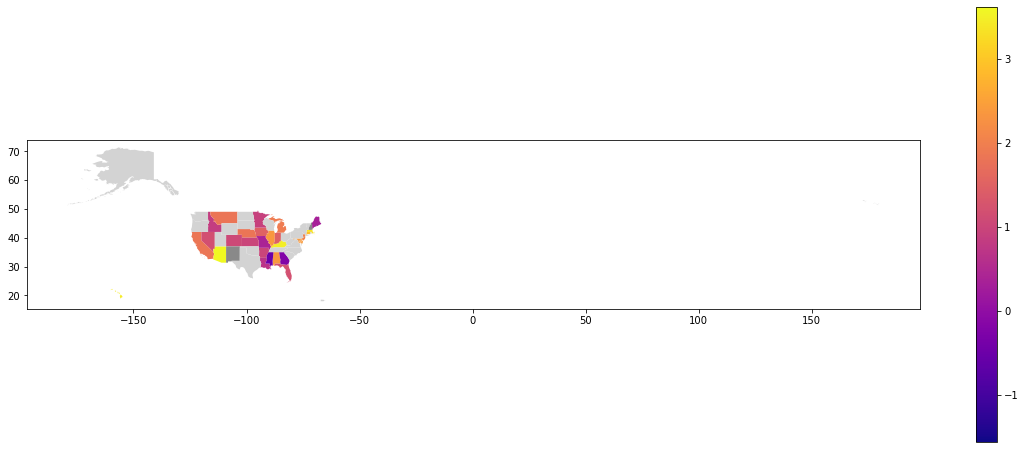

In [63]:
# plot state model coefficients

f, ax = plt.subplots(1,1,figsize=(20,20))
#counties.plot(ax=ax)
state_mod_geo[(state_mod_geo['P-Values']< 0.05)].plot(column='Coefficient', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
state_mod_geo[state_mod_geo.isna().any(axis=1)].plot(ax=ax, color='#D3D3D3') # make missing values grey
state_mod_geo[(state_mod_geo['P-Values']> 0.05)].plot(ax=ax, color='#898989') # make insiginificant values dark grey

#ax.set_facecolor('k')
#plt.title('Proportion of Greenery by County', fontsize=20)
#ax.legend(title='This is My Legend Title')

<BarContainer object of 36 artists>

Text(0.5, 0, 'Coefficients')

Text(0, 0.5, 'Variables')

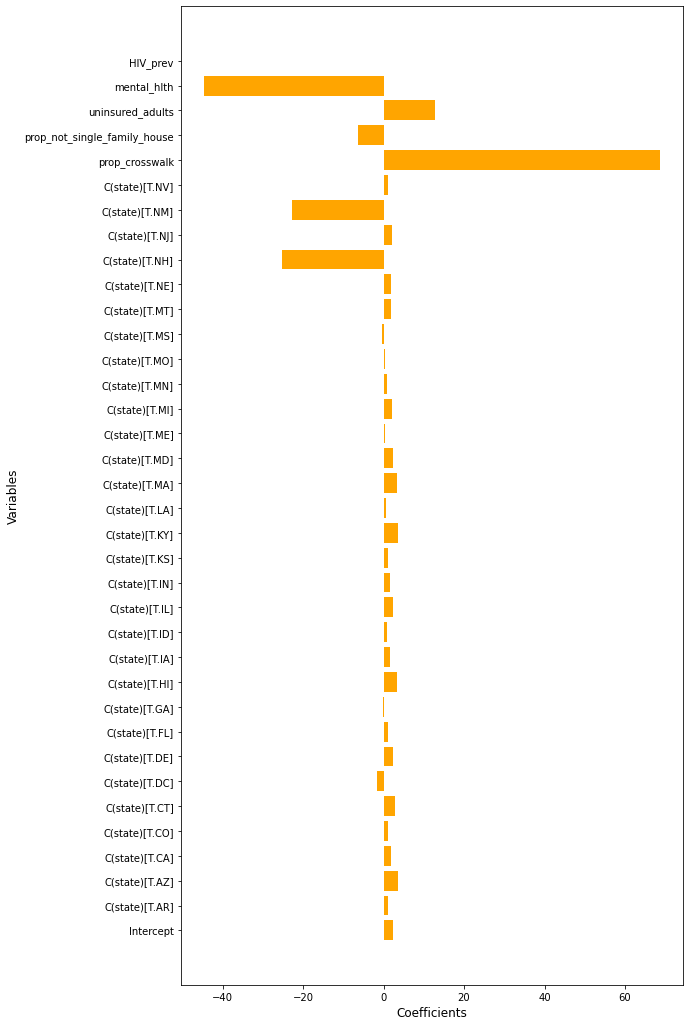

In [20]:
# set figure size, create bar graph
fig, ax = plt.subplots(figsize =(9, 18))
ax.barh(state_mod['Variable'], state_mod['Coefficient'], color = 'orange')

# add chart elements
#ax.set_title('Monthly War Casualties in Afghanistan', fontweight ='bold', fontsize = 15)
plt.xlabel('Coefficients', fontsize = 12)
plt.ylabel('Variables', fontsize = 12)

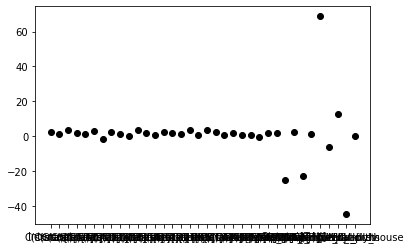

In [46]:
plt.plot(state_mod['Variable'], state_mod['Coefficient'], 'o', color='black')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          excess_deaths   No. Observations:                  251
Model:                            GLM   Df Residuals:                      104
Model Family:                 Poisson   Df Model:                          146
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22307.
Date:                Tue, 07 Dec 2021   Deviance:                       43431.
Time:                        23:45:51   Pearson chi2:                 5.26e+04
No. Iterations:                    30                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        2.1487      0.066     32.575      0.000       2.019       2.278
C(MSA_short)[T.Alexandria, LA]                                 -57.1772   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Ann Arbor, MI]                                    2.1427      0.065     33.005      0.000       2.015       2.270
C(MSA_short)[T.Athens-Clarke County, GA]                         0.7921      0.059     13.530      0.000       0.677       0.907
C(MSA_short)[T.Atlanta-Sandy Springs-Alpharetta, GA]            -0.3293      0.049     -6.658      0.000      -0.426      -0.232
C(MSA_short)[T.Auburn-Opelika, AL]                               1.4317      0.083     17.164      0.000       1.268       1.595
C(MSA_short)[T.Augusta-Richmond County, GA-SC]                 -28.4967   6.66e+04     -0.000      1.000   -1.31e+05     1.3e+05
C(MSA_short)[T.Baltimore-Columbia-Towson, MD]                    2.6840      0.058     46.238      0.000       2.570       2.798
C(MSA_short)[T.Barnstable Town, MA]                             -0.2312      0.149     -1.556      0.120      -0.522       0.060
C(MSA_short)[T.Baton Rouge, LA]                                -28.7028   6.43e+04     -0.000      1.000   -1.26e+05    1.26e+05
C(MSA_short)[T.Birmingham-Hoover, AL]                          -28.0719   8.14e+04     -0.000      1.000    -1.6e+05    1.59e+05
C(MSA_short)[T.Bloomington, IL]                                  2.1864      0.104     20.954      0.000       1.982       2.391
C(MSA_short)[T.Bloomington, IN]                                -28.0013   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Boise City, ID]                                 -26.9343   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Boston-Cambridge-Newton, MA-NH]                   2.6281      0.072     36.519      0.000       2.487       2.769
C(MSA_short)[T.Boulder, CO]                                      1.1341      0.077     14.793      0.000       0.984       1.284
C(MSA_short)[T.Cape Girardeau, MO-IL]                          -28.6128   1.16e+05     -0.000      1.000   -2.28e+05    2.28e+05
C(MSA_short)[T.Carbondale-Marion, IL]                            1.6253      0.091     17.813      0.000       1.446       1.804
C(MSA_short)[T.Carson City, NV]                                 -0.8239      0.080    -10.334      0.000      -0.980      -0.668
C(MSA_short)[T.Cedar Rapids, IA]                                 3.0230      0.077     39.455      0.000       2.873       3.173
C(MSA_short)[T.Champaign-Urbana, IL]                           -25.8273   1.16e+05     -0.000      1.000   -2.28e+05

## Plots of Results

In [ ]:
# plot of county/state results

f, ax = plt.subplots(1,1,figsize=(20,20))
#counties.plot(ax=ax)
gsv_counties.plot(column='prop_green', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
#ax.set_facecolor('k')
plt.title('Proportion of Greenery by County', fontsize=20)

## Exploratory Plots

In [ ]:
# create histogram of available excess health data
y = excess_deaths['Excess']

# convert all excess death values that are 0 to 1
y[y==0] = 1

# remove all rows that = 1
y = y[y!= 1]

# plot histogram of log y
plt.hist(np.log(y))

# add title and axis labels

plt.title('Distribution of Excess Deaths')
plt.xlabel('Log(excess deaths)')
plt.ylabel('Frequency')

#plt.savefig('available excess deaths data.png')

<AxesSubplot:>

Text(0.5, 1.0, 'Proportion of Greenery by County')

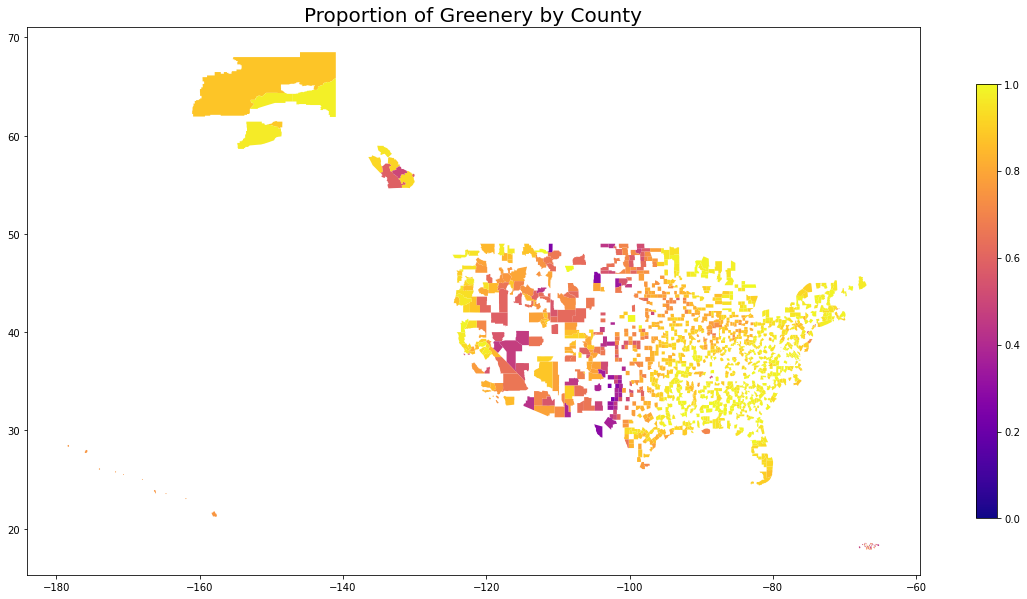

In [48]:
f, ax = plt.subplots(1,1,figsize=(20,20))
#counties.plot(ax=ax)
gsv_counties.plot(column='prop_green', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
#ax.set_facecolor('k')
plt.title('Proportion of Greenery by County', fontsize=20)

#ax.legend(title='This is My Legend Title')
#gsv_counties[gsv_counties.isna().any(axis=1)].plot(ax=ax, color='#D3D3D3')

<AxesSubplot:>

Text(0.5, 1.0, 'Proportion of Sidewalk by County')

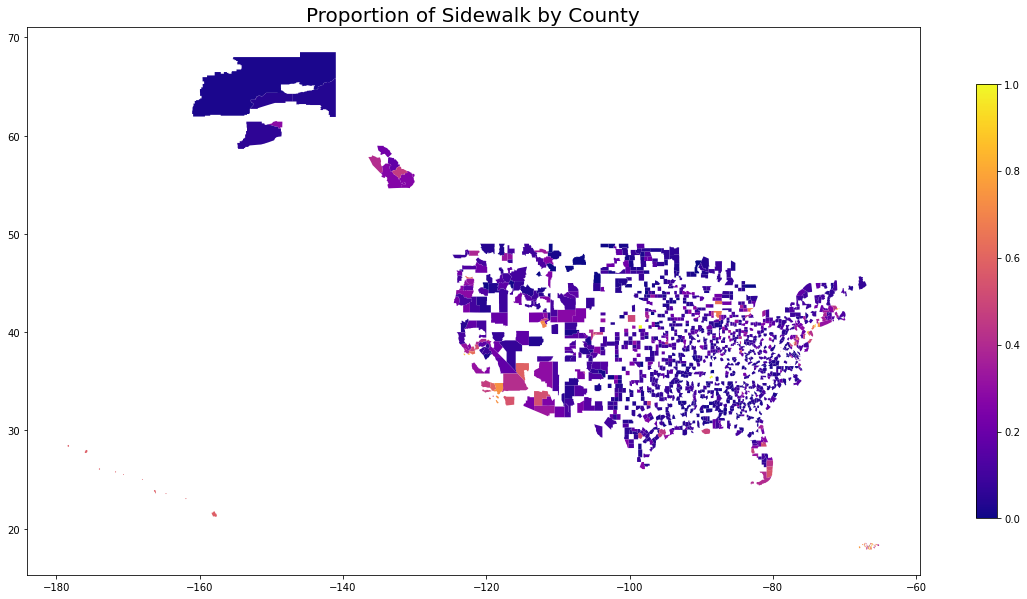

In [26]:
f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot('prop_sidewalk', ax=ax, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
#ax.set_facecolor('lightgray')

# add title
plt.title('Proportion of Sidewalk by County', fontsize=20)

#plt.savefig('not_single_family_homes.png')

<AxesSubplot:>

Text(0.5, 1.0, 'Proportion of Single Lane Roads by County')

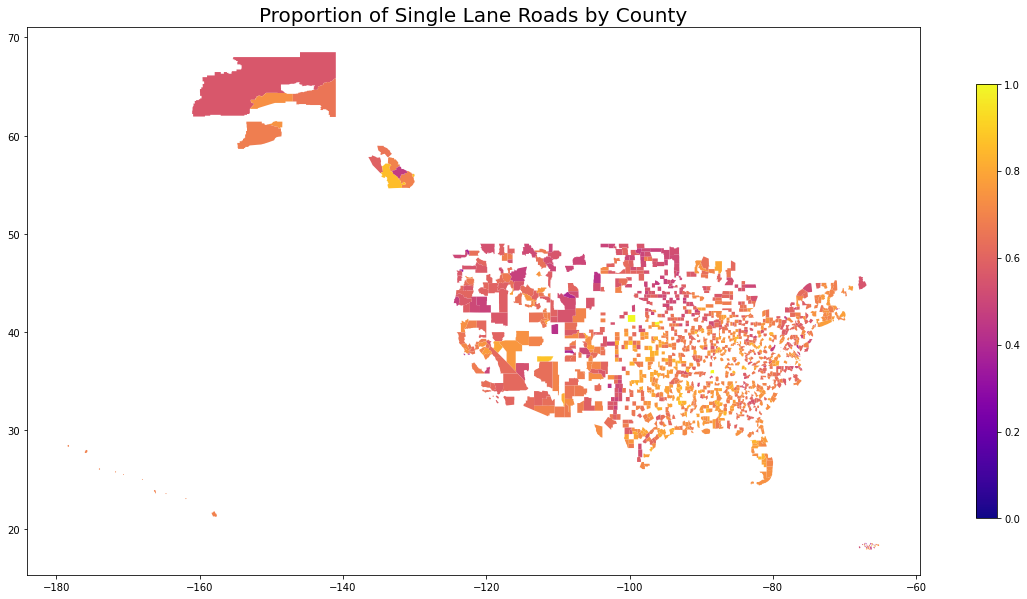

In [28]:
f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot('prop_single_lane', ax=ax, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
#ax.set_facecolor('lightgray')

# add title
plt.title('Proportion of Single Lane Roads by County', fontsize=20)

#plt.savefig('not_single_family_homes.png')

In [61]:
gsv_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2979 entries, 0 to 2978
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   county                        2979 non-null   int64   
 1   prop_green                    2979 non-null   float64 
 2   prop_crosswalk                2979 non-null   float64 
 3   prop_not_single_family_house  2979 non-null   float64 
 4   prop_single_lane              2979 non-null   float64 
 5   prop_triple_lane              2979 non-null   int64   
 6   prop_visible_wires            2979 non-null   float64 
 7   prop_sidewalk                 2979 non-null   float64 
 8   prop_dilapidated_building     2979 non-null   float64 
 9   STATEFP                       2979 non-null   object  
 10  COUNTYFP                      2979 non-null   object  
 11  COUNTYNS                      2979 non-null   object  
 12  GEOID                         2979 non-n

In [64]:
excess_county_health[['State', 'excess_deaths']].groupby('State').sum()

,excess_deaths
State,
AK,432
AL,8690
AR,6861
AZ,14097
CA,39411
CO,6368
CT,4743
DC,2088
DE,933
